# Assignment 3: Autoregressive Moving Average Models
Tasks:
1. Load dataset
2. Split your dataset into training and test datasets
3. Fit the parameters of the following models to your training dataset
    - AR(2)
    - ARMA(2,2)
4. Using the test dataset, compare the observations AR(2) and ARMA(2,2) predictions for the following lead times:
    - 1 time period ahead
    - 3 time period ahead
    - 5 time period ahead
5. Characterize the accuracy of the forecasts for each lead time and model (scatter plots, r2, rmse, etc.)
6. Comment on and contrast the modeling approaches

### 1. Initialize dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sm
from pandas.core import datetools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load BOII Agrimet ET dataset
df = pd.read_csv('BOII_ET_2007to2017.csv', names=['Y','M','D','ET'], skiprows=1)
# Format a better Date column
df['Date'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d')

# Create a Water Year column in the dataframe
WY = np.zeros(len(df['Y'].index)) 
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] 
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1
df['WY'] = WY.astype(int)

# Print check
qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

,Y,M,D,ET,Date,WY
0,2007,10,1,1.778,2007-10-01,2008
1,2007,10,2,2.286,2007-10-02,2008
2,2007,10,3,1.524,2007-10-03,2008
3,2007,10,4,1.270,2007-10-04,2008
4,2007,10,5,1.524,2007-10-05,2008
5,2007,10,6,2.286,2007-10-06,2008
6,2007,10,7,2.032,2007-10-07,2008
7,2007,10,8,3.556,2007-10-08,2008
8,2007,10,9,5.334,2007-10-09,2008
9,2007,10,10,3.302,2007-10-10,2008


### 2. Split data into training and test datasets

In [8]:
# The 'training' dataset will be all years prior to the last
# The 'test' dataset will be the last complete year to assess model accuracy
df_train = df[df.WY != 2017]
df_test  = df[df.WY == 2017]

# ET series of training values
ET = df_train['ET'].values
ETt = pd.Series(df_train['ET'].values,df_train['Date'].values)

### 3. Fit the parameters of the following models to your training dataset
- AR(2)
- ARMA(2,2)

#### AR(2)

In [10]:
# AR2 Parameters based on statsmodel library
ET_AR2_model = sm.AR(ETt).fit(2) # AR2
print('--Statsmodel AR2--')
print(ET_AR2_model.params)

# set variables for Y.W. calculations
ETtrain = df_train['ET'].values
ETtest  = df_test['ET'].values
DatesTest = df_test['Date'].values
ETttm1 = np.concatenate([ETtrain[-2:-1], ETtest[0:-1]])
ETttm2 = np.concatenate([ETtrain[-3:-1], ETtest[0:-2]])

# Y.W. AR2 Equation variables
AR2_mu   = ET_AR2_model.params[0]
AR2_phi1 = ET_AR2_model.params[1]
AR2_phi2 = ET_AR2_model.params[2]

# Y.W. AR2 Equation
EThatAR2 = AR2_mu + AR2_phi1*ETttm1 + AR2_phi2*ETttm2

--Statsmodel AR2--
const    0.153664
L1.y     0.661383
L2.y     0.282171
dtype: float64


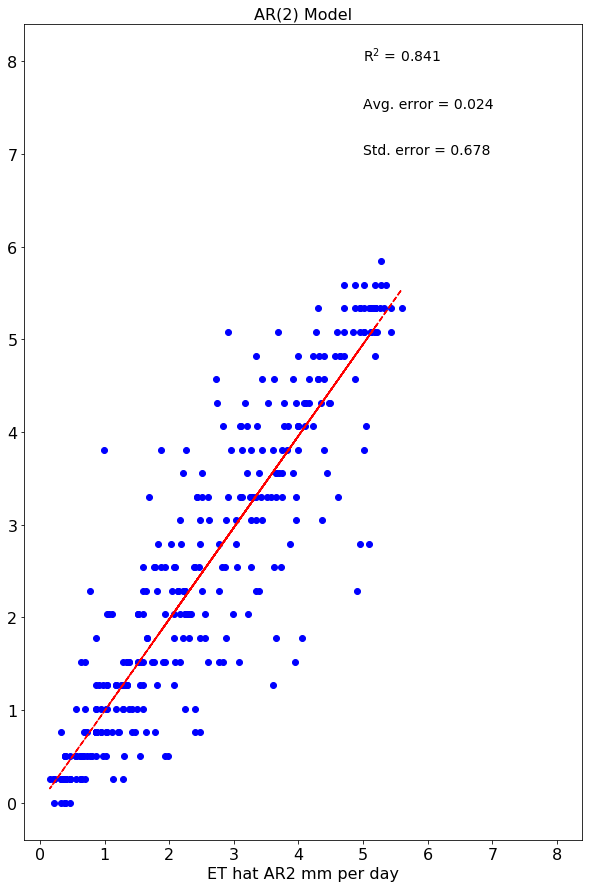

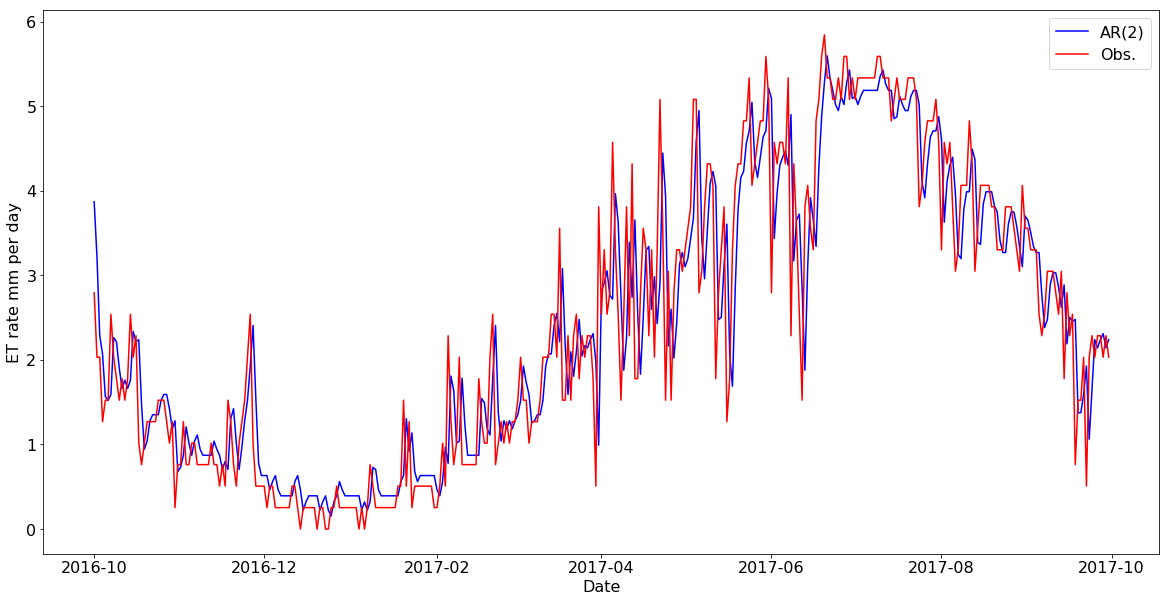

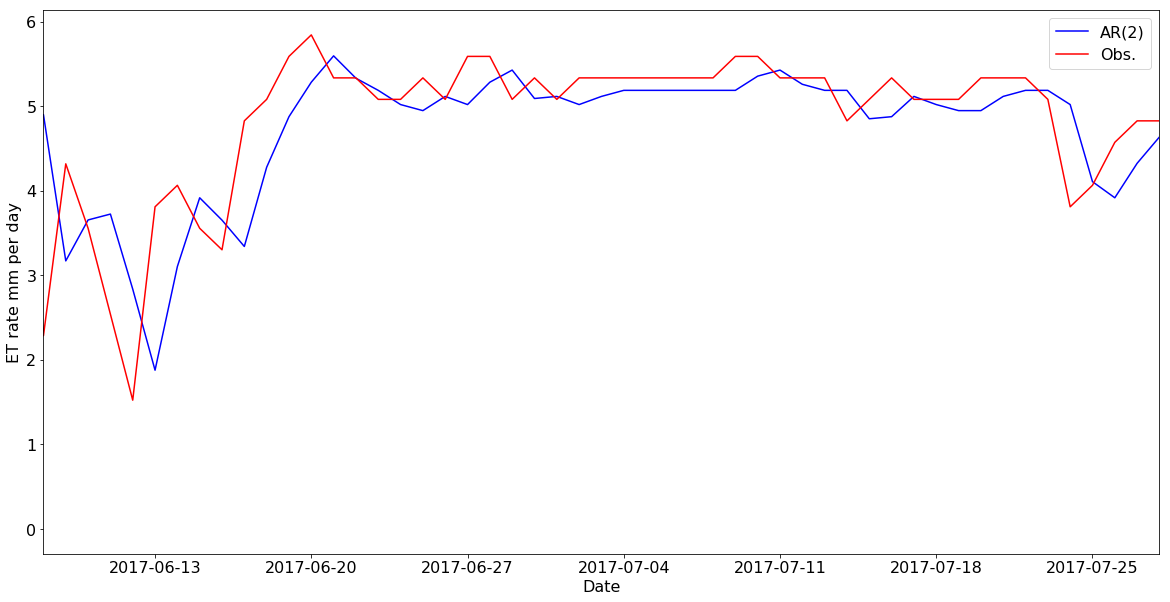

<function matplotlib.pyplot.show>

In [24]:
# Plot of AR(2) and Observations
plt.figure(figsize=(20,10))
plt.plot(DatesTest,EThatAR2,'b-')
plt.plot(DatesTest,ETtest,'r-')
plt.ylabel('ET rate mm per day',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

# Zoomed Plot of AR(2) and Observations
plt.figure(figsize=(20,10))
plt.plot(DatesTest,EThatAR2,'b-')
plt.plot(DatesTest,ETtest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('ET rate mm per day',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

# Statistics on AR(2) fit
# Compute the R^2 values for each prediction 
R2AR2  = np.corrcoef(EThatAR2,ETtest)**2
muAR2  = np.mean(EThatAR2-ETtest)
stdAR2 = np.std(EThatAR2-ETtest)

# Plot
plt.figure(figsize=(6,8))
plt.plot(EThatAR2,ETtest,'bo')
plt.plot([8, 8], [8, 8], 'k-')
plt.title('AR(2) Model',fontsize=16)
plt.xlabel('ET hat AR2 mm per day',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2[0,1], xy=(5,8), fontsize=14)
ax.annotate('Avg. error = %.3f'%muAR2, xy=(5,7.5), fontsize=14)
ax.annotate('Std. error = %.3f'%stdAR2, xy=(5,7), fontsize=14)
z = np.polyfit(EThatAR2, ETtest, 1)
p = np.poly1d(z)
plt.plot(EThatAR2,p(EThatAR2),"r--")
plt.show

#### ARMA(2,2)

In [25]:
# Fit ARMA(2,2) model using statsmodel of ET data
ET_ARMA_2_2_model = sm.ARMA(ETt-np.mean(ETt),(2,2)).fit()
print(ET_ARMA_2_2_model.params)

const     -0.024223
ar.L1.y    1.204623
ar.L2.y   -0.208800
ma.L1.y   -0.707730
ma.L2.y   -0.077896
dtype: float64


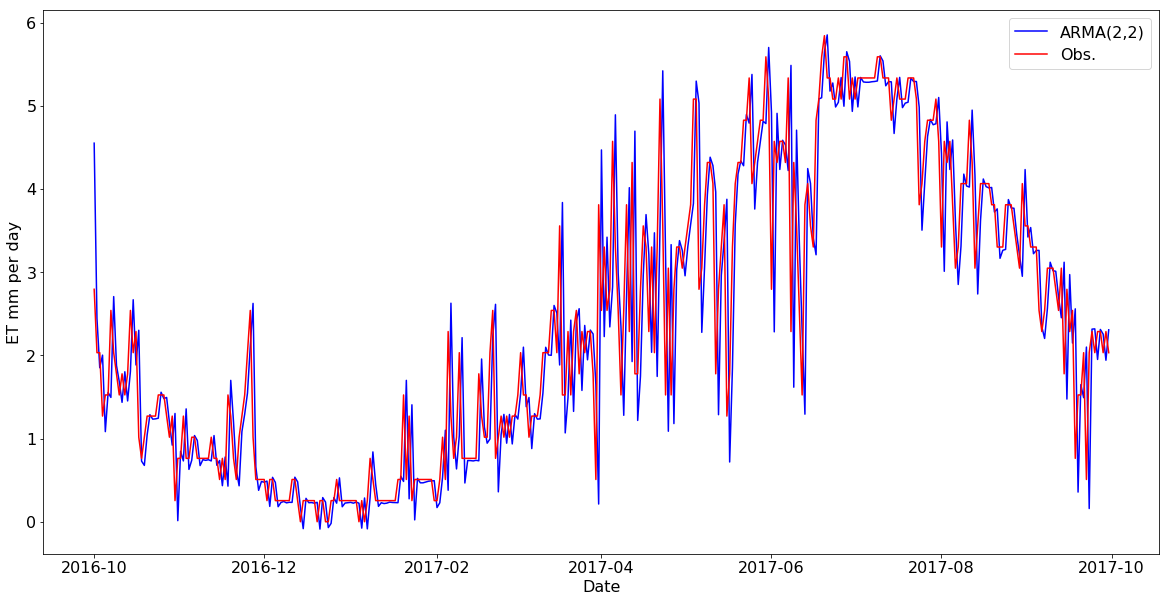

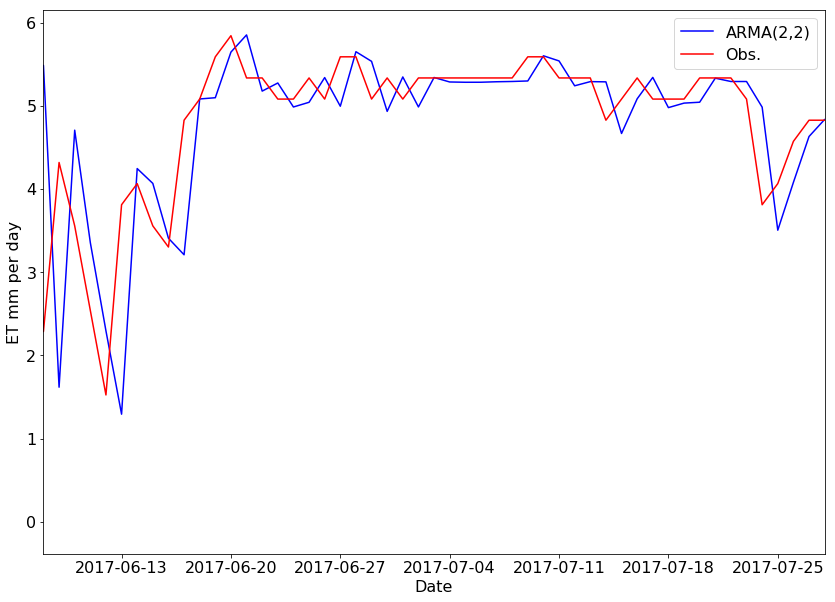

In [36]:
# Noise constant; Should be clsoe to AR2 stderror
noise_std = 0.01
#noise_std = stdAR2

# Training values
ETtrain = df_train['ET'].values
ETtrain = ETtrain.reshape(ETtrain.size,1)

# Test/Observation values
ETtest  = df_test['ET'].values
ETtest  = ETtest.reshape(ETtest.size,1)

# Plot range
DatesTest = df_test['Date'].values

# Z values
ETttm1 = np.concatenate([ETtrain[-2:-1],ETtest[0:-1]])
ETttm1 = ETttm1.reshape(ETttm1.size,1)
ETttm2 = np.concatenate([ETtrain[-3:-1],ETtest[0:-2]])
ETttm2 = ETttm2.reshape(ETttm2.size,1)
etatm1 = np.random.normal(0.0,noise_std,(len(ETttm1),1))
etatm2 = np.concatenate([np.random.normal(0.0,noise_std,(2,1)),etatm1[0:-2]])

# Model parameters
ARMA22_mu     = ET_ARMA_2_2_model.params[0]
ARMA22_phi1   = ET_ARMA_2_2_model.params[1]
ARMA22_phi2   = ET_ARMA_2_2_model.params[2]
ARMA22_theta1 = ET_ARMA_2_2_model.params[3]
ARMA22_theta2 = ET_ARMA_2_2_model.params[4]

# ARMA(2,2) Equation
EThatARMA22 = ARMA22_mu + ARMA22_phi1*ETttm1 + ARMA22_phi2*ETttm2 - ARMA22_theta1*etatm1 - ARMA22_theta2*etatm2

# Plot of ARMA(2,2) predictions vs Observed Values
plt.figure(figsize=(20,10))
plt.plot(DatesTest,EThatARMA22,'b-')
plt.plot(DatesTest,ETtest,'r-')
plt.ylabel('ET mm per day',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('ARMA(2,2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

# Plot of zoomed in section
plt.figure(figsize=(20,10))
plt.plot(DatesTest,EThatARMA22,'b-')
plt.plot(DatesTest,ETtest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('ET mm per day',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('ARMA(2,2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

### Characterize the accuracy of the forecasts for each lead time and model (i.e. scatter plots, r2, rmse, etc.)

### Comment on and contrast the modeling approaches